In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
def get_direct_subfolders(directory):
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    return subfolders

def get_direct_subfiles(directory):
    subfiles = [f.path for f in os.scandir(directory) if f.is_file()]
    return subfiles.sort(reverse = True)
data_path = r'/content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'


In [4]:
import os, torch, random, numpy as np, albumentations as A, nibabel as nib
from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import gc

class CustomSegmentationDataset(Dataset):

    def __init__(self, data_path, transformations=None):
        self.ims_t1c, self.ims_t1n, self.ims_t2f, self.ims_t2w, self.ims_gb, self.gts, self.patient_numbers = self.get_slices(data_path)
        self.transformations = transformations
        self.n_cls = 2

        assert len(self.ims_t1c) == len(self.gts)

    def __len__(self):
        return len(self.ims_t1c)

    def __getitem__(self, idx):
        im_t1c, im_t1n, im_t2f, im_t2w, im_gb, gt, patient_number = self.ims_t1c[idx], self.ims_t1n[idx], self.ims_t2f[idx], self.ims_t2w[idx], self.ims_gb[idx],self.gts[idx], self.patient_numbers[idx]
        if self.transformations:
            im_t1c, im_t1n, im_t2f, im_t2w, im_gb, gt = self.apply_transformations(im_t1c, im_t1n, im_t2f, im_t2w, im_gb, gt)

        # For visualization purposes
        im_t1c = self.preprocess_im(im_t1c)
        im_t1n = self.preprocess_im(im_t1n)
        im_t2f = self.preprocess_im(im_t2f)
        im_t2w = self.preprocess_im(im_t2w)
        im_gb = self.preprocess_im(im_gb)
        # For the cases when label equals to 2; to avoid CE Loss error
        gt[gt > 1] = 1

        return im_t1c.float(), im_t1n.float(), im_t2f.float(), im_t2w.float(), im_gb.float(), gt.unsqueeze(0).long(), patient_number

    def preprocess_im(self, im):
        max_val = torch.max(im)
        im[im < 0] = 0
        return im / max_val

    def get_slices(self, data_path):
        ims_t1c, ims_t1n, ims_t2f, ims_t2w, ims_t2w, ims_gb, gts, patient_numbers = [], [], [], [], [], [], [], []
        subfolders = get_direct_subfolders(data_path)
        subfolders.reverse()
        subfolders.sort()

        for subfolder in subfolders:
            print("Patient folder: ", subfolder)
            subfiles = get_direct_subfiles(subfolder)
            # paths:
            seg_file = os.path.join(subfolder, os.path.basename(subfolder) + "-seg.nii.gz")
            t1c_file = os.path.join(subfolder, os.path.basename(subfolder) + "-t1c.nii.gz")
            t1n_file = os.path.join(subfolder, os.path.basename(subfolder) + "-t1n.nii.gz")
            t2f_file = os.path.join(subfolder, os.path.basename(subfolder) + "-t2f.nii.gz")
            t2w_file = os.path.join(subfolder, os.path.basename(subfolder) + "-t2w.nii.gz")
            patient_numbers.append(os.path.basename(subfolder))

            nifti_img_seg = nib.load(seg_file)
            nifti_img_t1c = nib.load(t1c_file)
            nifti_img_t1n = nib.load(t1n_file)
            nifti_img_t2f = nib.load(t2f_file)
            nifti_img_t2w = nib.load(t2w_file)

            # Get the image data as a NumPy array
            img_data_seg = nifti_img_seg.get_fdata()
            img_data_t1c = nifti_img_t1c.get_fdata()
            img_data_t1n = nifti_img_t1n.get_fdata()
            img_data_t2f = nifti_img_t2f.get_fdata()
            img_data_t2w = nifti_img_t2w.get_fdata()

            # Find the index of the frame with the most pixels above zero
            nonzero_counts = [np.count_nonzero(slice_img) for slice_img in img_data_seg.transpose(2, 0, 1)]
            max_index = np.argmax(nonzero_counts)
            # Extract the frame with the most pixels above zero
            selected_frame_seg = img_data_seg[:, :, max_index]
            selected_frame_t1c = img_data_t1c[:, :, max_index]
            selected_frame_t1n = img_data_t1n[:, :, max_index]
            selected_frame_t2f = img_data_t2f[:, :, max_index]
            selected_frame_t2w = img_data_t2w[:, :, max_index]

            del nifti_img_seg
            del nifti_img_t1c
            del nifti_img_t1n
            del nifti_img_t2f
            del nifti_img_t2w

            del img_data_seg
            del img_data_t1c
            del img_data_t1n
            del img_data_t2f
            del img_data_t2w

            gts.append(selected_frame_seg)
            ims_t1c.append(selected_frame_t1c)
            ims_t1n.append(selected_frame_t1n)
            ims_t2f.append(selected_frame_t2f)
            ims_t2w.append(selected_frame_t2w)
            ims_gb.append(np.array((selected_frame_t1c, selected_frame_t1n,
                      selected_frame_t2f, selected_frame_t2w)))
            gc.collect()

            if len(ims_t1c) == 5:
                break
        return ims_t1c, ims_t1n, ims_t2f, ims_t2w, ims_gb, gts, patient_numbers

    def apply_transformations(self, im_t1c, im_t1n, im_t2f, im_t2w, im_gb, gt):
        transformed = self.transformations(image=im_t1c, image_t1n=im_t1n, image_t2f=im_t2f, image_t2w=im_t2w, image_gb=im_gb, mask=gt)
        return transformed["image"], transformed["image_t1n"], transformed["image_t2f"], transformed["image_t2w"],transformed["image_gb"], transformed["mask"]

def get_dls(path, transformations, bs, ns=4):
    ds = CustomSegmentationDataset(data_path=path, transformations=transformations)
    n_cls = ds.n_cls

    print(f"There are {len(ds)} number of images in the test set\n")
    _, _, test_ds = torch.utils.data.random_split(ds, [0, 0, len(ds)])

    # Get dataloaders
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=ns)

    return test_dl, n_cls


Patient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000
Patient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00002-000
Patient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00003-000
Patient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00005-000
Patient folder:  /content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00006-000
There are 5 number of images in the test set



ValueError: num must be an integer with 1 <= num <= 20, not 21

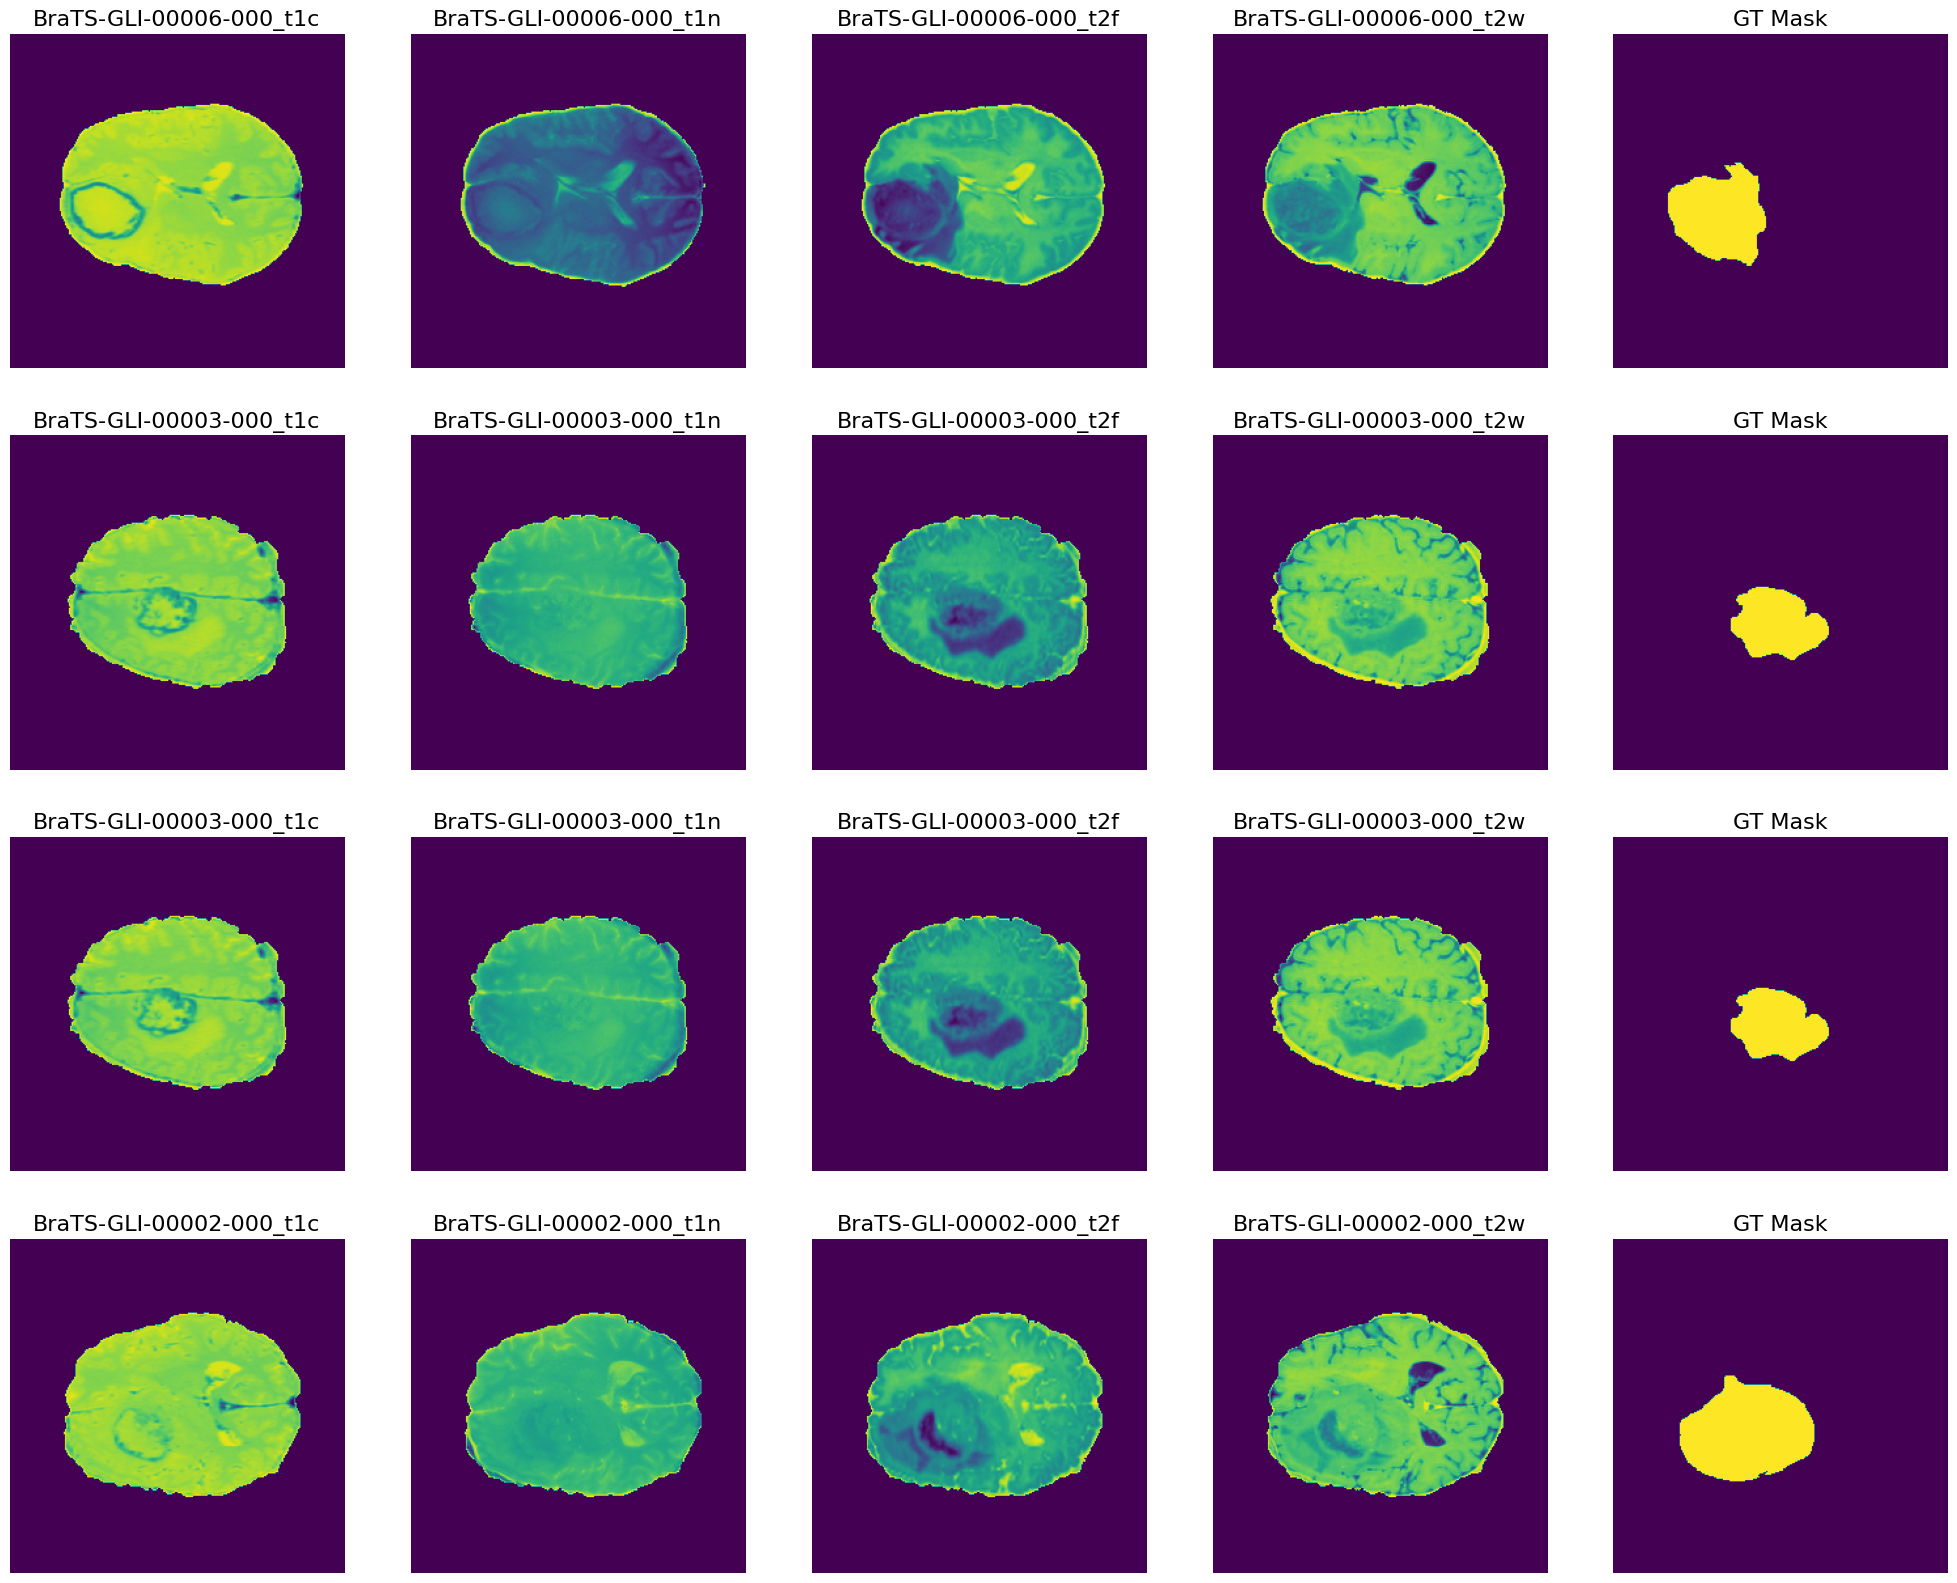

In [5]:
def plot(rows, cols, count, im, gt=None, title="Original Image", title_size=16):
    plt.subplot(rows, cols, count)
    plt.imshow(im.squeeze(0).float()) if gt else plt.imshow((im * 255).cpu().permute(1, 2, 0).numpy().astype("uint8") * 255)
    plt.axis("off")
    plt.title(title, fontsize=title_size)
    return count + 1


def visualize(ds, n_ims):
    plt.figure(figsize=(25, 20))
    rows = n_ims // 5
    cols = 5
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):
        if count == n_ims + 1:
            break
        im_t1c, im_t1n, im_t2f, im_t2w,_, gt, patient_number = ds[index]

        # T1C Plot
        count = plot(rows, cols, count, im=im_t1c, title=patient_number+"_t1c")
        # T1N Plot
        count = plot(rows, cols, count, im=im_t1n, title=patient_number+"_t1n")
        # T2F Plot
        count = plot(rows, cols, count, im=im_t2f, title=patient_number+"_t2f")
        # T2w Plot
        count = plot(rows, cols, count, im=im_t2w, title=patient_number+"_t2w")
        # Second Plot
        count = plot(rows, cols, count, im=gt.squeeze(0), gt=True, title="GT Mask")

    plt.show()

# Path to data directory
data_path =r'/content/drive/MyDrive/Brats21 Data/Dataset/training/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'

# Image height and width for resizing
im_h, im_w = 256, 256

# Transformations
trans = A.Compose([
    A.Resize(im_h, im_w),
    ToTensorV2(transpose_mask=True)
],is_check_shapes=False, additional_targets={
    'image_t1n': 'image', 'image_t2f': 'image', 'image_t2w': 'image', 'image_gb': 'image'
})

# Get dataloader and number of classes
test_dl, n_cls = get_dls(path=data_path, transformations=trans, bs=16)

# Visualize the dataset
visualize(test_dl.dataset, n_ims=24)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load the model and set the device
model_t1c = torch.load(f"/content/drive/MyDrive/Brats21 Data/models/brats_best_model_t1c.pt")
model_t1c = model_t1c.to(device)

model_t1n = torch.load(f"/content/drive/MyDrive/Brats21 Data/models/brats_best_model_t1n.pt")
model_t1n = model_t1n.to(device)

model_t2f = torch.load(f"/content/drive/MyDrive/Brats21 Data/models/brats_best_model_t2f.pt")
model_t2f = model_t2f.to(device)

model_t2w = torch.load(f"/content/drive/MyDrive/Brats21 Data/models/brats_best_model_t2w.pt")
model_t2w = model_t2w.to(device)

model_global = torch.load(f"/content/drive/MyDrive/Brats21 Data/models/brats_best_model_global.pt")
model_global = model_global.to(device)

<ipython-input-14-99444edba334>:92: RuntimeWarning: overflow encountered in scalar add
  count_vote = pred_t1c[i,j] +pred_t1n[i,j] +pred_t2f[i,j]*2 +pred_t2w[i,j]


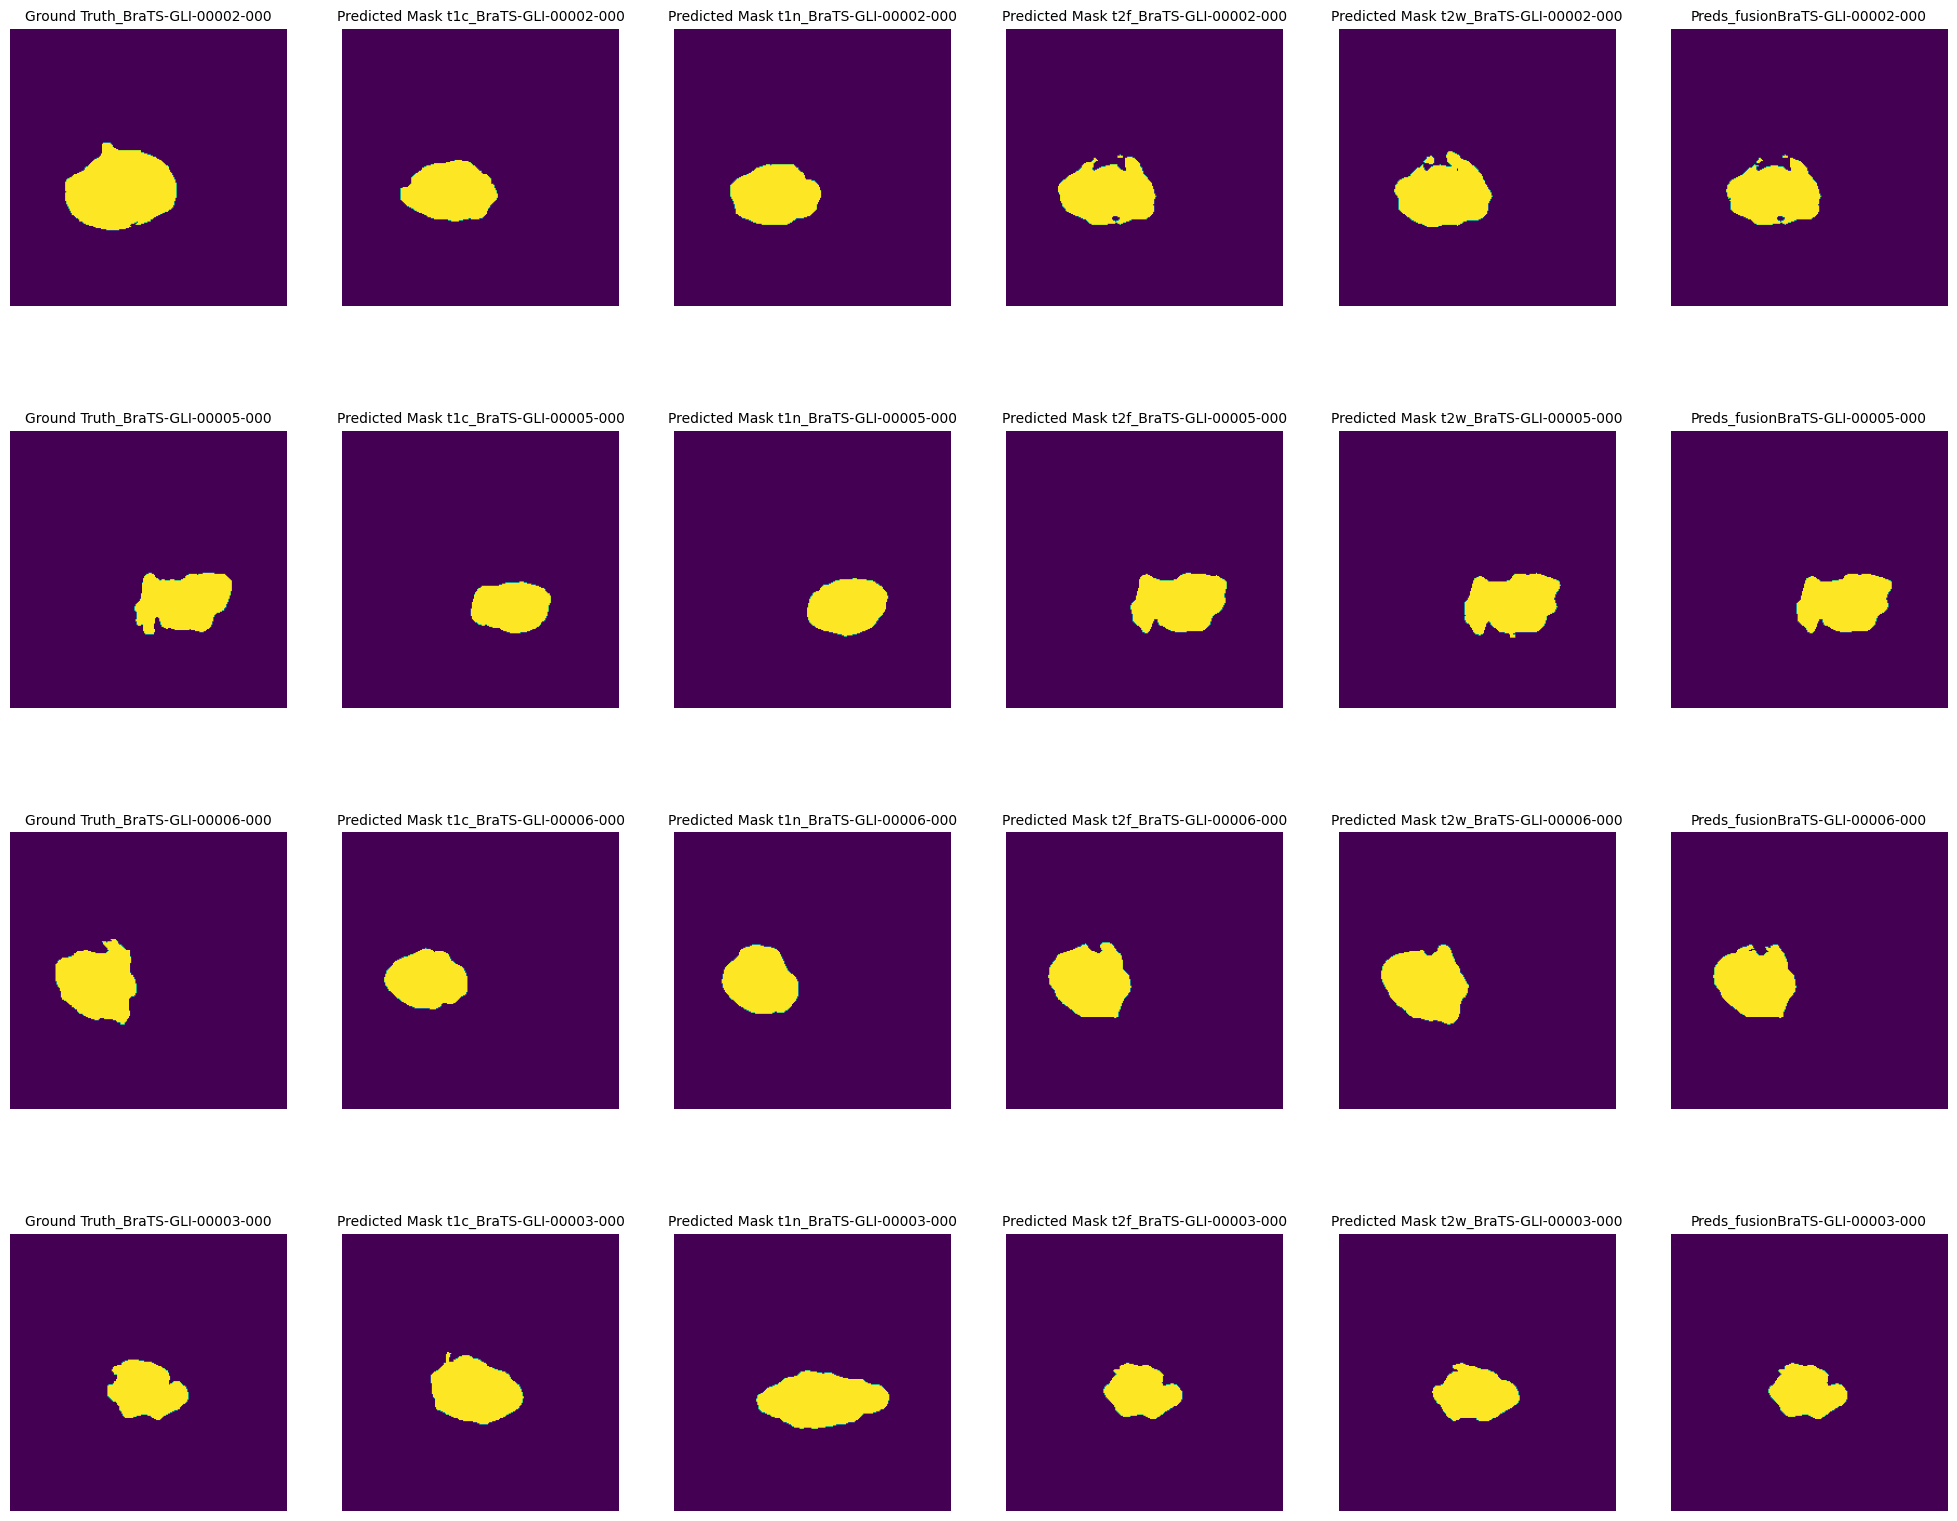

In [14]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import cv2
def plot2(rows, cols, count, im, gt=None, title="Original Image", title_size=16):
    plt.subplot(rows, cols, count)
    plt.imshow(im)
    plt.axis("off")
    plt.title(title, fontsize=title_size)
    return count + 1
def to_numpy(pred):
        pred = pred.squeeze(0).float().cpu().numpy()  # Make sure tensor is on CPU and convert to NumPy
        pred = (pred * 255).astype(np.uint8)  # Convert to uint8 type and scale if necessary
        return pred
def inference(dl, model_t1c,model_t1n,model_t2f,model_t2w,model_global, device, n_ims=25):
    cols = n_ims // 6
    rows = n_ims // cols

    count = 1
    ims_t1c, ims_t1n, ims_t2f, ims_t2w, ims_gb, gts, preds_t1c, preds_t1n, preds_t2f, preds_t2w,preds_gb,patients_numbers = [], [], [], [], [], [], [], [], [], [], [], []

    tr_iou_, tr_pa_, tr_mse_ = 0, 0, 0
    for idx, data in enumerate(dl):
        im_t1c, im_t1n, im_t2f, im_t2w,im_gb, gt, patient_number  = data
        patients_numbers.append(patient_number)
        # Move images and ground truths to the same device as the model
        im_t1c = im_t1c.to(device)
        im_t1n = im_t1n.to(device)
        im_t2f = im_t2f.to(device)
        im_t2w = im_t2w.to(device)
        #im_gb = torch.tensor(im_gb)

        im_gb = im_gb.to(device)
        gt = gt.to(device)

        # Get predicted mask
        with torch.no_grad():
            pred_t1c = torch.argmax(model_t1c(im_t1c), dim=1)
            pred_t1n = torch.argmax(model_t1n(im_t1n), dim=1)
            pred_t2f = torch.argmax(model_t2f(im_t2f), dim=1)
            pred_t2w = torch.argmax(model_t2w(im_t2w), dim=1)
            pred_gb = torch.argmax(model_global(im_gb), dim=1)

            #save_image(pred, patient_number[0]+'.png')

        # Ensure pred and gt are on the same device
        pred_t1c = pred_t1c.to(device)
        pred_t1n = pred_t1n.to(device)
        pred_t2f = pred_t2f.to(device)
        pred_t2w = pred_t2w.to(device)
        pred_gb = pred_gb.to(device)
        gt = gt.to(device)

#        met = Metrics(pred, gt, loss_fn, n_cls=n_cls)
#        print("patient number ",patient_number)
#        print("IOU : ", met.PA())
#        tr_pa_ += met.PA()
#        print("MSE : ", met.mse_loss().item())
#        print()
#        tr_mse_ += met.mse_loss().item()
        ims_t1c.append(im_t1c.cpu())  # Move to CPU for plotting
        ims_t1n.append(im_t1n.cpu())  # Move to CPU for plotting
        ims_t2f.append(im_t2f.cpu())  # Move to CPU for plotting
        ims_t2w.append(im_t2w.cpu())  # Move to CPU for plotting

        gts.append(gt.cpu())  # Move to CPU for plotting
        preds_t1c.append(pred_t1c.cpu())  # Move to CPU for plotting
        preds_t1n.append(pred_t1n.cpu())  # Move to CPU for plotting
        preds_t2f.append(pred_t2f.cpu())  # Move to CPU for plotting
        preds_t2w.append(pred_t2w.cpu())  # Move to CPU for plotting
        preds_gb.append(pred_gb.cpu())
    plt.figure(figsize=(25, 20))
    for idx, (im_t1c, im_t1n, im_t2f, im_t2w, gt, pred_t1c, pred_t1n, pred_t2f, pred_t2w, pred_gb,patient_number) in enumerate(zip(ims_t1c, ims_t1n, ims_t2f, ims_t2w, gts, preds_t1c, preds_t1n, preds_t2f, preds_t2w,preds_gb,patients_numbers)):
        if idx == cols:
            break
        print()
        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth_"+patient_number[0],title_size=10)
        count = plot(cols, rows, count, im=pred_t1c, title="Predicted Mask t1c_"+patient_number[0],title_size=10)
        count = plot(cols, rows, count, im=pred_t1n, title="Predicted Mask t1n_"+patient_number[0],title_size=10)
        count = plot(cols, rows, count, im=pred_t2f, title="Predicted Mask t2f_"+patient_number[0],title_size=10)
        count = plot(cols, rows, count, im=pred_t2w, title="Predicted Mask t2w_"+patient_number[0],title_size=10)


        pred_t1c=to_numpy(pred_t1c)
        pred_t1n=to_numpy(pred_t1n)
        pred_t2f=to_numpy(pred_t2f)
        pred_t2w=to_numpy(pred_t2w)
        pred_gb=to_numpy(pred_gb)
        pred_fusion = np.zeros_like(pred_t1c)
        for i in range(pred_t2w.shape[0]):
          for j in range(pred_t2w.shape[1]):
            count_vote = pred_t1c[i,j] +pred_t1n[i,j] +pred_t2f[i,j]*2 +pred_t2w[i,j]

            if count_vote >= 3*255:
              pred_fusion[i,j] = 255
        # Second plot
        count = plot2(cols, rows, count, im=pred_fusion, title="Preds_fusion"+patient_number[0],title_size=10)


    return  tr_pa_ / n_ims, tr_mse_ / n_ims



# Run inference
tr_pa_, tr_mse_ = inference(test_dl, model_t1c,model_t1n,model_t2f,model_t2w, model_global, device=device)


# Metrics

In [8]:
import segmentation_models_pytorch as Unet, time
from tqdm import tqdm
from torch.nn import functional as F

model = Unet.DeepLabV3Plus(classes = n_cls, in_channels = 240)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(pred, dim = 1) > 0, gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_, self.device = loss_fn, eps, n_cls, pred, device

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)
    def mse_loss(self):
      output = self.pred.float()  # Convert output to float
      target = self.gt.float()  # Convert target to float
      return F.mse_loss(output, target).float()
    def loss(self): return self.loss_fn(self.pred_, self.gt.squeeze(1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s]


<ipython-input-15-5c98a065bf05>:73: RuntimeWarning: overflow encountered in scalar add
  count_vote = pred_t1c_np[i,j] +pred_t1n_np[i,j] +pred_t2f_np[i,j]*2 +pred_t2w_np[i,j]


pred_fusion_np  [  0 255]
pred_t1c_np  [  0 255]
patient number  ('BraTS-GLI-00002-000',)
PA lf :  0.940338134765625
IOU lf :  0.9403381347656251

patient number  ('BraTS-GLI-00002-000',)
PA gb:  0.9273681640625
IOU gb:  0.46368408203126055


pred_fusion_np  [  0 255]
pred_t1c_np  [  0 255]
patient number  ('BraTS-GLI-00005-000',)
PA lf :  0.942626953125
IOU lf :  0.9426269531250001

patient number  ('BraTS-GLI-00005-000',)
PA gb:  0.9637603759765625
IOU gb:  0.48188018798830234


pred_fusion_np  [  0 255]
pred_t1c_np  [  0 255]
patient number  ('BraTS-GLI-00006-000',)
PA lf :  0.94134521484375
IOU lf :  0.9413452148437501

patient number  ('BraTS-GLI-00006-000',)
PA gb:  0.9453582763671875
IOU gb:  0.4726791381836078


pred_fusion_np  [  0 255]
pred_t1c_np  [  0 255]
patient number  ('BraTS-GLI-00003-000',)
PA lf :  0.9607696533203125
IOU lf :  0.9607696533203126

patient number  ('BraTS-GLI-00003-000',)
PA gb:  0.9266510009765625
IOU gb:  0.4633255004882917


pred_fusion_np  [  0 255

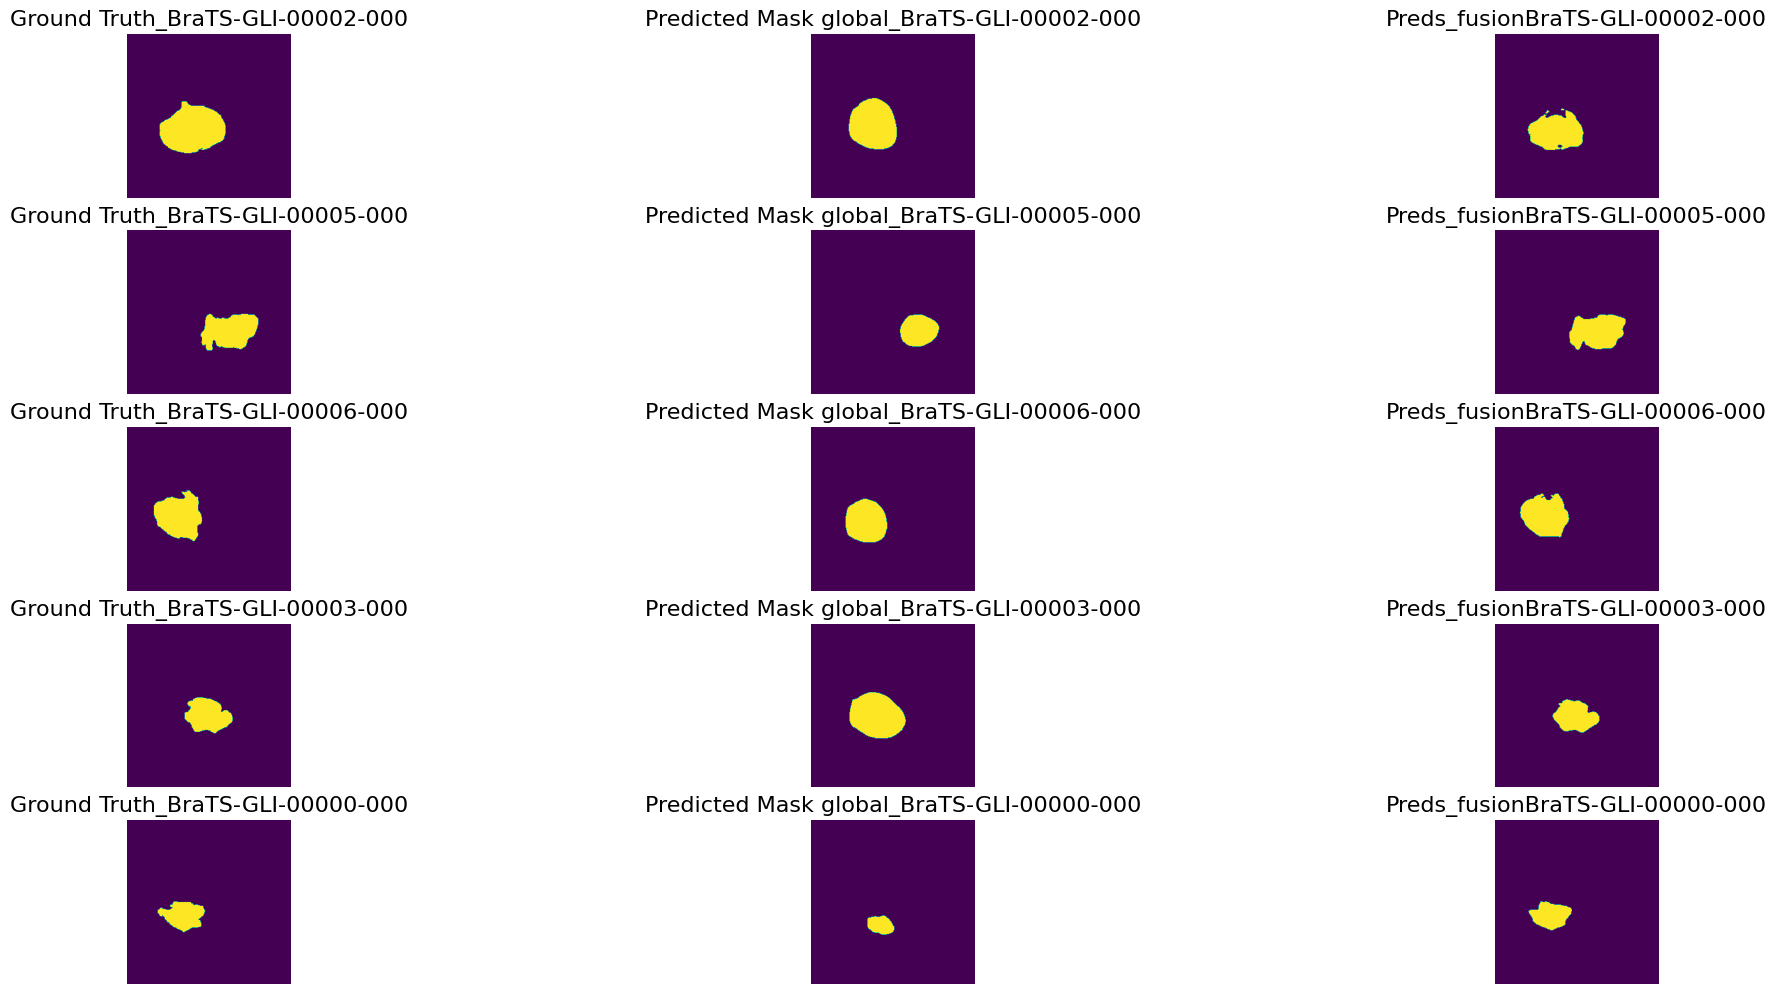

In [15]:
import torch.nn.functional as F
import math
def inference2(dl, model_t1c,model_t1n,model_t2f,model_t2w,model_global, device, n_ims=25):
    cols = n_ims // 3
    rows = n_ims // cols

    count = 1
    ims_t1c, ims_t1n, ims_t2f, ims_t2w, ims_gb, gts, preds_t1c, preds_t1n, preds_t2f, preds_t2w,preds_gb,patients_numbers = [], [], [], [], [], [], [], [], [], [], [], []

    tr_iou_, tr_pa_gb_, tr_pa_lf_, tr_IOU_lf_, tr_IOU_gb_ = 0, 0, 0, 0, 0
    for idx, data in enumerate(dl):
        im_t1c, im_t1n, im_t2f, im_t2w,im_gb, gt, patient_number  = data
        patients_numbers.append(patient_number)
        # Move images and ground truths to the same device as the model
        im_t1c = im_t1c.to(device)
        im_t1n = im_t1n.to(device)
        im_t2f = im_t2f.to(device)
        im_t2w = im_t2w.to(device)
        #im_gb = torch.tensor(im_gb)

        im_gb = im_gb.to(device)
        gt = gt.to(device)

        # Get predicted mask
        with torch.no_grad():
            pred_t1c = torch.argmax(model_t1c(im_t1c), dim=1)
            pred_t1n = torch.argmax(model_t1n(im_t1n), dim=1)
            pred_t2f = torch.argmax(model_t2f(im_t2f), dim=1)
            pred_t2w = torch.argmax(model_t2w(im_t2w), dim=1)
            pred_gb = torch.argmax(model_global(im_gb), dim=1)

            #save_image(pred, patient_number[0]+'.png')

        # Ensure pred and gt are on the same device
        pred_t1c = pred_t1c.to(device)
        pred_t1n = pred_t1n.to(device)
        pred_t2f = pred_t2f.to(device)
        pred_t2w = pred_t2w.to(device)
        pred_gb = pred_gb.to(device)




        ims_t1c.append(im_t1c.cpu())  # Move to CPU for plotting
        ims_t1n.append(im_t1n.cpu())  # Move to CPU for plotting
        ims_t2f.append(im_t2f.cpu())  # Move to CPU for plotting
        ims_t2w.append(im_t2w.cpu())  # Move to CPU for plotting

        gts.append(gt.cpu())  # Move to CPU for plotting
        preds_t1c.append(pred_t1c.cpu())  # Move to CPU for plotting
        preds_t1n.append(pred_t1n.cpu())  # Move to CPU for plotting
        preds_t2f.append(pred_t2f.cpu())  # Move to CPU for plotting
        preds_t2w.append(pred_t2w.cpu())  # Move to CPU for plotting
        preds_gb.append(pred_gb.cpu())
    plt.figure(figsize=(25, 20))
    for idx, (im_t1c, im_t1n, im_t2f, im_t2w, gt, pred_t1c, pred_t1n, pred_t2f, pred_t2w, pred_gb,patient_number) in enumerate(zip(ims_t1c, ims_t1n, ims_t2f, ims_t2w, gts, preds_t1c, preds_t1n, preds_t2f, preds_t2w,preds_gb,patients_numbers)):
        if idx == cols:
            break

        count = plot(cols, rows, count, im=gt.squeeze(0), gt=True, title="Ground Truth_"+patient_number[0])
        count = plot(cols, rows, count, im=pred_gb, title="Predicted Mask global_"+patient_number[0])

        pred_t1c_np=to_numpy(pred_t1c)
        pred_t1n_np=to_numpy(pred_t1n)
        pred_t2f_np=to_numpy(pred_t2f)
        pred_t2w_np=to_numpy(pred_t2w)
        gt_np=to_numpy(gt)


        pred_fusion_np = np.zeros_like(pred_t1c_np)
        for i in range(pred_t2w_np.shape[0]):
          for j in range(pred_t2w_np.shape[1]):
            count_vote = pred_t1c_np[i,j] +pred_t1n_np[i,j] +pred_t2f_np[i,j]*2 +pred_t2w_np[i,j]

            if count_vote >= 3*255:
              pred_fusion_np[i,j] = 255
        # Second plot
        print("pred_fusion_np ",np.unique(pred_fusion_np))
        print("pred_t1c_np ",np.unique(gt_np))
        count = plot2(cols, rows, count, im=pred_fusion_np, title="Preds_fusion"+patient_number[0])

        pred_fusion = torch.tensor(pred_fusion_np)
        #pred_fusion = F.interpolate(pred_fusion.unsqueeze(0), size=(1,1,256,256), mode='bilinear', align_corners=False).squeeze(0)


        met_lf = Metrics(gt, pred_fusion, loss_fn, n_cls=n_cls)
        print("patient number ",patient_number)
        print("PA lf : ", met_lf.PA())
        tr_pa_lf_ += met_lf.PA()
        print("IOU lf : ", met_lf.mIoU().item())
        print()
        tr_IOU_lf_ += met_lf.mIoU().item()



        met_gb = Metrics(gt, pred_gb, loss_fn, n_cls=n_cls)

        print("patient number ",patient_number)
        print("PA gb: ", met_gb.PA())
        tr_pa_gb_ += met_gb.PA()
        print("IOU gb: ", met_gb.mIoU().item())
        print()
        tr_IOU_gb_ += met_gb.mIoU().item()
        print()



    return  tr_pa_gb_/len(dl), tr_IOU_lf_ / len(dl), tr_IOU_gb_ /len(dl), tr_pa_lf_/ len(dl)



# Run inference
tr_pa_gb_, tr_IOU_lf_,tr_IOU_gb_,tr_pa_lf_= inference2(test_dl, model_t1c,model_t1n,model_t2f,model_t2w, model_global, device=device)
print( "Global PA of Early Fusion: ",round(tr_pa_gb_,3)," Global mIoU of Early Fusion: ",round(tr_IOU_gb_,3))
print( "Global PA of Late Fusion: ",round(tr_pa_lf_,3)," Global mIoU of Late Fusion: ",round(tr_IOU_lf_,3))

